In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import graphviz
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

## Data

In [2]:
# Read data
data = pd.read_csv('churn.csv')

# Drop the 'customerID' column
data = data.drop(columns=['customerID'])

# Check for missing values
if data.isnull().values.any():
    print('There are missing values in the DataFrame.')
else:
    print('No missing values.')

# Display first 5 rows
data.head()

No missing values.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Cleaning

In [3]:
# Step 1: Replace specific values in the dataset
# Replace 'No phone service' and 'No internet service' with 'No' for consistency
data.replace({'No phone service': 'No', 'No internet service': 'No'}, inplace=True)

# Step 2: Map gender and binary columns
# Mapping 'Male' to 1 and 'Female' to 0 in the 'gender' column
data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})

# Define the binary columns that need to be mapped from 'Yes'/'No' to 1/0
binary_columns = ['MultipleLines', 'Partner', 'Dependents', 'PhoneService', 
                  'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                  'TechSupport', 'StreamingTV', 'StreamingMovies', 
                  'PaperlessBilling', 'Churn']

# Apply the mapping ('Yes' -> 1, 'No' -> 0) to all binary columns
for col in binary_columns:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define categorical columns to be one-hot encoded
cat_columns = ['InternetService', 'Contract', 'PaymentMethod']

# Apply one-hot encoding to the categorical columns
data = pd.get_dummies(data, columns=cat_columns)

# Step 4: Convert 'TotalCharges' column to numeric
# Convert the 'TotalCharges' column to numeric, coercing errors to NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Step 5: Drop rows with missing 'TotalCharges' values
# Drop rows where 'TotalCharges' is NaN after the conversion
data_cleaned = data.dropna(subset=['TotalCharges'])

# Step 6: Display the shape of the cleaned data to confirm rows are dropped
print(f"Shape of cleaned data: {data_cleaned.shape}")

Shape of cleaned data: (7032, 27)


# Random Forest: Base model

In [4]:
# X,y definitions
X = data_cleaned.drop('Churn', axis=1)  # Dropping the target variable from features
y = data_cleaned['Churn']  # Target variable (churn)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100,random_state=42,class_weight='balanced')

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model
print(f'\nAccuracy Score: {accuracy_score(y_test, y_pred):.2f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))


Accuracy Score: 0.79

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [5]:
# Predict probabilities for the test data
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (Churn)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f'ROC AUC Score: {roc_auc:.2f}')

ROC AUC Score: 0.82


## Confusion Matrix: Base model

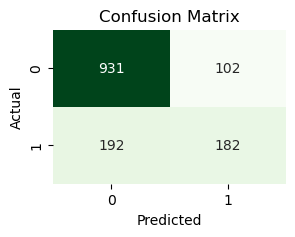

In [6]:
# Define the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a nice confusion matrix with a heatmap
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

# Random Forest (feature reduction)

## Feature importance

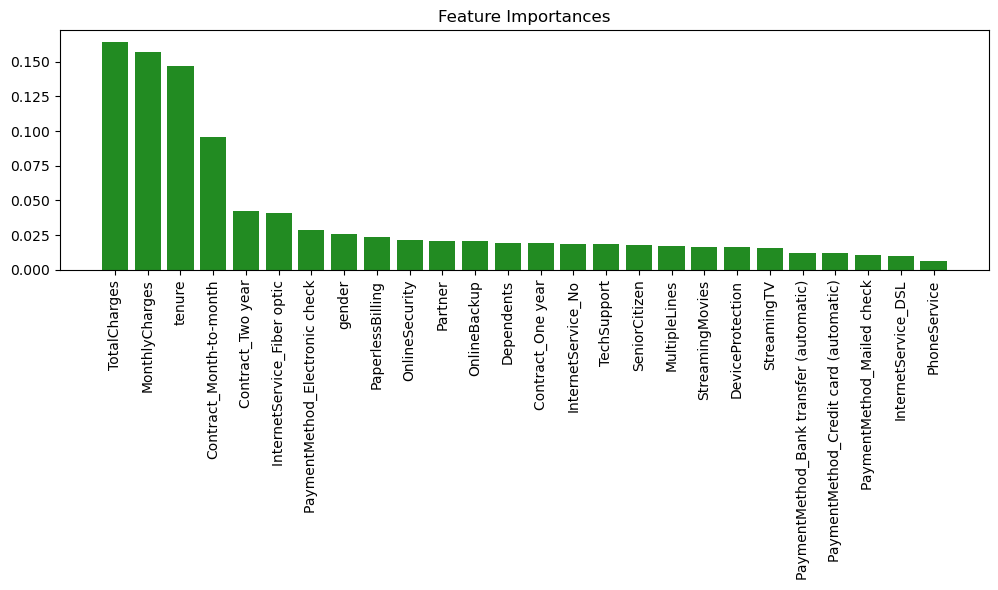

In [7]:
# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
bars = plt.bar(range(X_train.shape[1]), importances[indices], align='center',color='forestgreen')
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

## Filter

In [8]:
# Get feature importances
importances = rf.feature_importances_

# Set the threshold for dropping features
threshold = 0.02

# Identify the features to keep
features_to_keep = X.columns[importances > threshold]

# Filter the dataset to include only those features
X_train_reduced = X_train[features_to_keep]
X_test_reduced = X_test[features_to_keep]
X_test_reduced.shape

(1407, 12)

## Re-train model

In [9]:
# Train the model again using the reduced feature set
rf_reduced = RandomForestClassifier(random_state=42,class_weight='balanced')
rf_reduced.fit(X_train_reduced, y_train)

# Evaluate the model
y_pred = rf_reduced.predict(X_test_reduced)

# Get the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy after feature reduction: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy after feature reduction: 0.77
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1033
           1       0.58      0.47      0.52       374

    accuracy                           0.77      1407
   macro avg       0.70      0.67      0.68      1407
weighted avg       0.76      0.77      0.76      1407



## Confusion Matrix: Feature reduced model

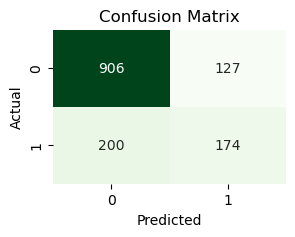

In [10]:
# Define the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a nice confusion matrix with a heatmap
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

# Precision-Recall Trade-off

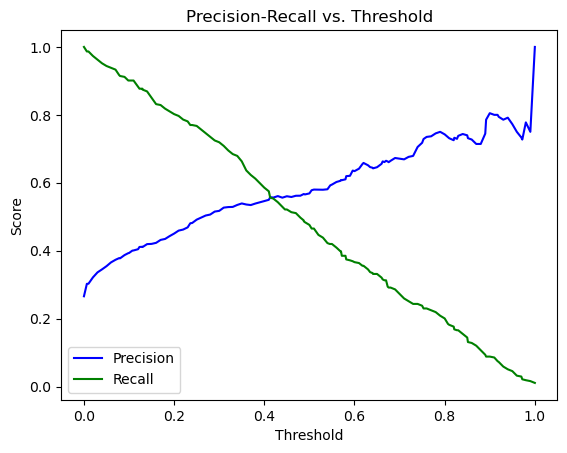

In [11]:
# Get predicted probabilities for class 1 (churn)
y_probs = rf_reduced.predict_proba(X_test_reduced)[:, 1]

# Plot precision-recall curve to visualize threshold trade-offs
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall',color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision-Recall vs. Threshold')
plt.show()

## Maximizing F1-score subject to threshold

In [12]:
# Initialize variables to store the best threshold and the best F1 score
best_threshold = 0.0
best_f1 = 0.0

# Iterate over thresholds to find the best threshold based on F1-score
for threshold in [i / 100 for i in range(1, 51)]:
    # Convert probabilities to class predictions based on the current threshold
    y_pred_new = (y_probs >= threshold).astype(int)
    
    # Calculate F1-score for class 1 (churn)
    f1 = f1_score(y_test, y_pred_new, pos_label=1)
    
    # Track the threshold that gives the best F1-score
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_pred = y_pred_new

# Output the best threshold and corresponding F1 score
print(f'Best Threshold: {best_threshold}')
print(f'Best F1-Score: {best_f1:.2f}')

# Evaluate the model with the best threshold
accuracy = accuracy_score(y_test, best_pred)
print(f'Accuracy after using best threshold: {accuracy:.2f}')
print(classification_report(y_test, best_pred))

Best Threshold: 0.31
Best F1-Score: 0.60
Accuracy after using best threshold: 0.75
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1033
           1       0.53      0.71      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.79      0.75      0.76      1407



# ROC Curve

ROC-AUC: 0.80


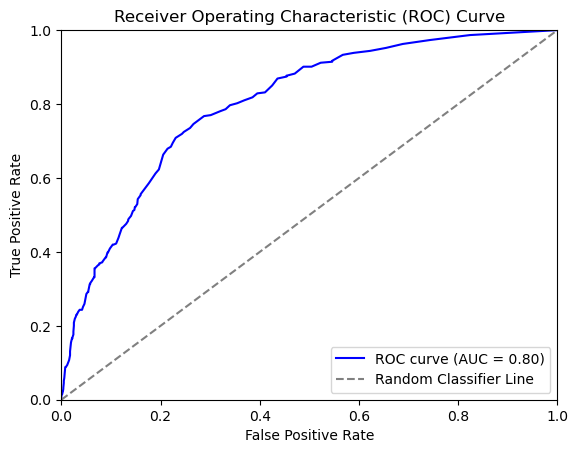

In [13]:
# Compute ROC curve (False Positive Rate, True Positive Rate) and thresholds
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)

# Compute the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_probs)
print(f'ROC-AUC: {roc_auc:.2f}')

# Plot ROC, Random Classifier Line
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()